# RNN

Given a sequence, predict the topic distribution for it

In [65]:
import unicodedata
import string
import re
import random
import time
import math
import csv

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import os

import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader

# the dists are saved as comma separated values in a string (because pandas can't save datatype as int)
# so to read as numeric-values, you must split on spaces and convert to float.
# Michael says there is an efficient way to do this.

In [66]:
print(torch.__version__)

0.3.1


Here is our dataset

In [67]:
df = pd.read_csv('data.csv')
df.head()

,sentences,dists
0,By,0.000215766137942 0.000241668597233 0.00020097...
1,Beth Stebner Tara Brady,0.000117660461174 0.000123021350745 0.00012870...
2,PUBLISHED :,0.000574640958915 0.000137269205565 0.00015039...
3,"13:57 EST , 21 January 2013",0.000117660461174 0.000123021350745 0.00012870...
4,|,0.000215766137942 0.000241668597233 0.00020097...


In [68]:
df.shape

(1174, 2)

Methods for cleaning up data

In [69]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

And generating a vocabulary

In [70]:
SOS_token = 0
EOS_token = 1

class Voc:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [71]:
# TRAINING_CUTOFF = 900

# # choose a random sentence and its corresponding distribution (label)
# def choose_random_training_pair():
#     training_pair = df.loc[random.randint(0, df.shape[0] - TRAINING_CUTOFF)]

#     sentence = training_pair['sentences']
#     distribution = training_pair['dists']

#     return sentence, distribution

# def choose_random_testing_pair():
#     testing_pair = df.loc[random.randint(0, df.shape[0] + TRAINING_CUTOFF - 1)]

#     sentence = testing_pair['sentences']
#     distribution = testing_pair['dists']

#     return sentence, distribution

def generate_vocabulary(sentences):
    # create the vocabulary
    vocabulary = Voc('source_identification')
    for sentence in sentences:
        vocabulary.index_words(sentence)

    return vocabulary

Lets define our Dataset class

In [72]:
class DailyMailDataset(Dataset):
    def __init__(self, csv_file, transform=False):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        
        self._clean_df()
        
        self.max_sentence_size = int(self.df['sentences'].apply(lambda x: len(x.split(" "))).max())
        
        self.vocabulary = generate_vocabulary(self.sentences())
        
        if transform:
            self.transform = ToTensor(self.vocabulary)
        else:
            self.transform = None
    
    def _clean_df(self):
        # normalize sentences
        self.df['sentences'] = self.df['sentences'].apply(normalize_string)
        
        # clean up any empty sentences
        self.df = self.df[df['sentences'].str.strip() != '']
        
        # convert back to original distribution
        self.df['dists'] = self.df['dists'].str.split(" ")
        self.df['dists'] = self.df['dists'].apply(lambda x: [float(i) for i in x])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.loc[idx].to_dict()
        
        if self.transform:
            sample['max_sentence_size'] = self.max_sentence_size
            sample = self.transform(sample)

        return sample
    
    def sentences(self):
        return self.df['sentences'].tolist()
    
    def distributions(self):
        return self.df['dists'].tolist()
    
    def head(self):
        return self.df.head()

And some transformation functions to get our data in tensor/variable format

In [73]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')]

def tensor_from_sentence(voc, sentence, padding):
    indexes = indexes_from_sentence(voc, sentence)
    indexes.append(EOS_token)
    sen_tensor = torch.LongTensor(indexes)
    
    # add padding
    sen_tensor = torch.cat((sen_tensor, torch.LongTensor(padding).zero_()), 0)

    return sen_tensor.view(-1, 1)

def tensor_from_distribution(distribution):
    return torch.FloatTensor(distribution).view(-1, 1) # TODO: convert to double tensor?

class ToTensor(object):
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary

    def __call__(self, sample):
        sentence, distribution, max_sentence_size = sample['sentences'], sample['dists'], sample['max_sentence_size']
        
        padding = max_sentence_size - len(sentence.split(" "))
        
        return {'sentences': tensor_from_sentence(self.vocabulary, sentence, padding),
                'dists': tensor_from_distribution(distribution)}

In [74]:
dataset = DailyMailDataset('data.csv', transform=True)
dataset.head()

,sentences,dists
0,by,"[0.000215766137942, 0.000241668597233, 0.00020..."
1,beth stebner tara brady,"[0.000117660461174, 0.000123021350745, 0.00012..."
2,published,"[0.000574640958915, 0.000137269205565, 0.00015..."
3,est january,"[0.000117660461174, 0.000123021350745, 0.00012..."
4,,"[0.000215766137942, 0.000241668597233, 0.00020..."


In [75]:
dataset[0]

{'dists': 
 1.00000e-04 *
  2.1577
  2.4167
  2.0097
    ⋮    
  2.3395
  1.8371
  2.2585
 [torch.FloatTensor of size 4406x1], 'sentences': 
     2
     1
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
 [torch.LongTensor of size 59x1]}

In [76]:
OUTPUT_SIZE = len(dataset.distributions()[0])
OUTPUT_SIZE

4406

In [77]:
n_words = dataset.vocabulary.n_words
n_words

3980

Let the ML begin

In [78]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"

In [79]:
USE_CUDA = False

Here's the RNN

In [80]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # embedding contains input_size vectors of size hidden_size.
        # this performs the word embeddings
        self.embedding = nn.Embedding(input_size, hidden_size)

        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        batch_size, seq_len = word_inputs.size()
        
        # embedding: (sentence length, batch size, word embedding length)
        embedded = self.embedding(word_inputs)
        embedded = embedded.transpose(0, 1)
        
        # GRU:
        #    input: (length of sequence, batch size, size of var in sequence)
        #    output: 
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self, batch_size):
        hidden = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [81]:
class classifierNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(classifierNN, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        self.i2o = nn.Linear(input_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, result_input):
        output = self.i2o(result_input)
        output = self.softmax(output)
        return output

Here's our training function

In [82]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_var, target, rnn, rnn_optimizer, classifier_optimizer, criterion):

    # Zero gradients of both optimizers
    rnn_optimizer.zero_grad()
    classifier_optimizer.zero_grad()
    
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    batch_size, input_length = input_var.size()

    # Run sentence through rnn
    hidden_var = rnn.init_hidden(batch_size)
    output_var, hidden_var = rnn(input_var, hidden_var)
    
    # duke's trick: we hard code the last variable in the output to be
    # a hidden representation of the distribution
    hidden_distribution = output_var[-1]
    
    # run classification rnn to get distribution
    output_distribution = classifier(output_var[-1])
    
    # compute loss
    loss = criterion(output_distribution, target)

    # run backprop
    loss.backward()
    torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)
    
    rnn_optimizer.step()
    classifier_optimizer.step()
    
    return loss.data[0]

Helper functions for time

In [83]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

This is where we actually train the RNN  
.  
.  
.  
.  
.  
.  
.  
.  
.  
after we initialize stuff

In [84]:
hidden_size = 500 # size of each word embedding
batch_size = 4
n_layers = 2 # number of layers for the RNN
dropout_p = 0.05 # we never use this

# Initialize the RNN
rnn = RNN(n_words, hidden_size, n_layers)

num_topics = 24

# Initialize the classifier NN
classifier = classifierNN(hidden_size, OUTPUT_SIZE)

# Move models to GPU
if USE_CUDA:
    rnn.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
rnn_optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
criterion = nn.KLDivLoss()

In [85]:
# Configuring training
n_epochs = 2
plot_every = 20
print_every = 10

# Keep track of time elapsed and running averages
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [86]:
# initialize data loader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Aaaaand now we actually start training

In [87]:
start = time.time()

total_cycles = len(dataloader) * n_epochs
cycle = 0

for epoch in range(1, n_epochs + 1):
    for i_batch, sample_batched in enumerate(dataloader):
        
        cycle += 1

        # Get training data for this cycle
        training_sentence, target_distribution = sample_batched['sentences'], sample_batched['dists']
        
        # convert to variables
        # we squeeze to get rid of the extra last dimension
        training_sentence = Variable(training_sentence.squeeze(2))
        target_distribution = Variable(target_distribution.squeeze(2))

        # Run the train function
        loss = train(training_sentence, target_distribution, rnn, rnn_optimizer, classifier_optimizer, criterion)

        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss

        if i_batch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print_summary = '%s (%d %d%%) %.10f' % (time_since(start, cycle / total_cycles), cycle, cycle / total_cycles * 100, print_loss_avg)
            print(print_summary)

        if i_batch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

0m 1s (- 12m 29s) (1 0%) 0.0000142540
0m 12s (- 10m 37s) (11 1%) 0.0001164592
0m 21s (- 9m 46s) (21 3%) 0.0001065673
0m 31s (- 9m 19s) (31 5%) 0.0001054681
0m 40s (- 9m 0s) (41 6%) 0.0000936471
0m 49s (- 8m 44s) (51 8%) 0.0001032879
1m 0s (- 8m 41s) (61 10%) 0.0000977221
1m 10s (- 8m 34s) (71 12%) 0.0000905169
1m 20s (- 8m 24s) (81 13%) 0.0000846487
1m 30s (- 8m 13s) (91 15%) 0.0000880641
1m 41s (- 8m 11s) (101 17%) 0.0000878966
1m 56s (- 8m 21s) (111 18%) 0.0000819623
2m 11s (- 8m 25s) (121 20%) 0.0000816906
2m 21s (- 8m 12s) (131 22%) 0.0000822565
2m 32s (- 8m 4s) (141 23%) 0.0000760319
2m 43s (- 7m 53s) (151 25%) 0.0000803067
2m 54s (- 7m 43s) (161 27%) 0.0000804144
3m 8s (- 7m 38s) (171 29%) 0.0000787862
3m 18s (- 7m 27s) (181 30%) 0.0000799827
3m 31s (- 7m 19s) (191 32%) 0.0000804650
3m 41s (- 7m 7s) (201 34%) 0.0000801423
3m 52s (- 6m 55s) (211 35%) 0.0000773734
4m 4s (- 6m 45s) (221 37%) 0.0000808484
4m 13s (- 6m 31s) (231 39%) 0.0000765847
4m 22s (- 6m 17s) (241 40%) 0.00007552

Plot losses

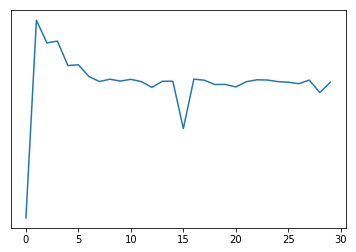

In [88]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

Lets evaulate our model

In [106]:
def evaluate(sentence, target_distribution):
    # Get size of input and target sentences
    batch_size, input_length = sentence.size()

    # Run sentence through rnn
    hidden_var = rnn.init_hidden(batch_size)
    output_var, hidden_var = rnn(sentence, hidden_var)
    
    # duke's trick: we hard code the last variable in the output to be
    # a hidden representation of the distribution
    hidden_distribution = output_var[-1]
    
    # run classification rnn to get distribution
    output_distribution = classifier(output_var[-1])
    
    # compute loss (not sure what other metric to evaluate on)
    loss = criterion(output_distribution, target_distribution)
    
    return loss.data[0], output_distribution

In [112]:
sentence, distribution = dataset[0]['sentences'], dataset[0]['dists']

sentence_var = Variable(sentence.transpose(0, 1))
distribution_var = Variable(distribution.transpose(0, 1))
loss, output_var = evaluate(sentence_var, distribution_var)

print(loss)
print(output_var)
print(distribution_var)

2.2300482669379562e-05
Variable containing:
-7.6346 -8.7385 -8.5356  ...  -8.6939 -8.3758 -8.6114
[torch.FloatTensor of size 1x4406]

Variable containing:
1.00000e-04 *
 2.1577  2.4167  2.0097  ...   2.3395  1.8371  2.2585
[torch.FloatTensor of size 1x4406]

